<a href="https://colab.research.google.com/github/achrafbalij/Sentiment-Analysis-on-Financial-News/blob/main/SENTIMENT_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment Analysis on Financial Data**

### **1. Imports and Setups**

#### 1.0. Imports

In [1]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 4.8 MB/s 
     |████████████████████████████████| 163 kB 66.0 MB/s 
     |████████████████████████████████| 7.6 MB 49.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 432 kB 4.6 MB/s 
     |████████████████████████████████| 115 kB 74.3 MB/s 
     |████████████████████████████████| 212 kB 62.1 MB/s 
     |████████████████████████████████| 127 kB 71.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
import pandas as pd
import nltk
import re
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from collections import Counter, defaultdict

from datasets import Dataset
import torch
import transformers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,precision_score,accuracy_score,f1_score

from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments, DistilBertTokenizerFast,DistilBertForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#### 1.1. Setting up GPU

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


### **2. Exploratory Data Analysis and Data Processing**

#### **2.1. Understanding the data**

For this project, we are going to use the kaggle Dataset "FinancialPhraseBank", it contains the sentiments for financial news headlines from the perspective of a retail investor.
Here is the link to the dataset: https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news

Our data contains 4846 observations and no missing values.

The data is partitioned into:
- Neutral: 59.41%
- Positive: 28.13%
- Negative: 12.46% 

In [4]:
url='https://raw.githubusercontent.com/achrafbalij/Sentiment-Analysis-on-Financial-News/main/all-data.csv'
data=pd.read_csv(url, encoding="cp1252",header=None)
data.columns = ['sentiment', 'text']

In [5]:
data

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [ ]:
data.shape

(4846, 2)

In [ ]:
data.isna().sum()

sentiment    0
text         0
dtype: int64

In [ ]:
data.sentiment.value_counts()/data.shape[0]

neutral     0.594098
positive    0.281263
negative    0.124639
Name: sentiment, dtype: float64

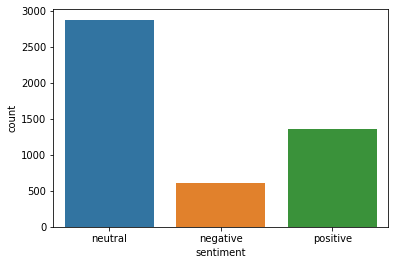

In [ ]:
sns.countplot(x="sentiment", data=data)

#### **2.2. Pre-processing**
#### Data cleaning:
* Remove punctuation.
* Remove stop word.
* Normalize (by applying a Stemmer or a Lemmatizer ).
* Set all characters to lowercase.
* Remove numbers (or convert numbers to * textual representations).


In [6]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def cleaning_data(text):
  text = str(text).lower()
  text = text.replace('{html}', "")
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', text)
  rem_url=re.sub(r'http\S+', '',cleantext)
  rem_num = re.sub('[0-9]+', '', rem_url)
  tokenizer = RegexpTokenizer(r'\w+')
  tokens = tokenizer.tokenize(rem_num)  
  filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
  stem_words=[stemmer.stem(w) for w in filtered_words]
  lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
  return " ".join(filtered_words)
data['text']=data['text'].map(lambda s:cleaning_data(s)) 

#### **Wordcloud**

Wordcloud is a visual representation of words. It enable anyone to quickly identify and visualize patterns in sentiment data so that insights can be realized, communicated easily and shared among teams

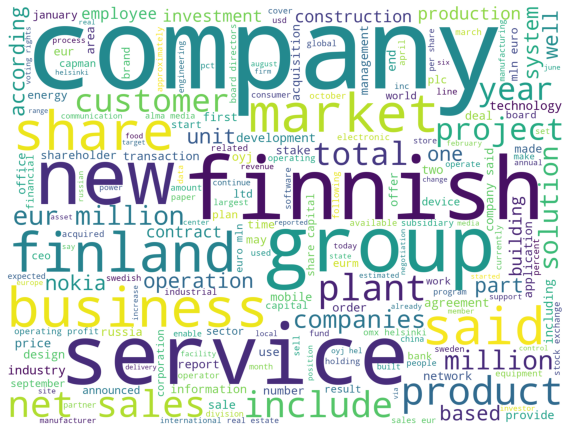

In [ ]:
def plot_wordcloud(data):
  words = ' '.join(data['text'])
  no_urls_no_tags = " ".join([word for word in words.split()])

  wordcloud = WordCloud(stopwords=STOPWORDS,
                        background_color='white',
                        width=2000,
                        height=1500
                      ).generate(no_urls_no_tags)

  plt.figure(1,figsize=(10, 10))
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

plot_wordcloud(data[data['sentiment']=='neutral'])

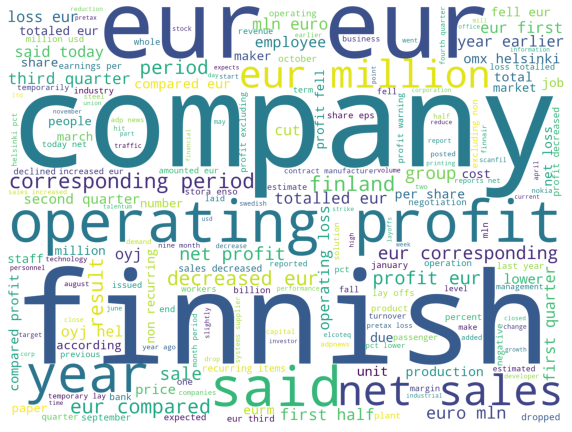

In [ ]:
plot_wordcloud(data[data['sentiment']=='negative'])

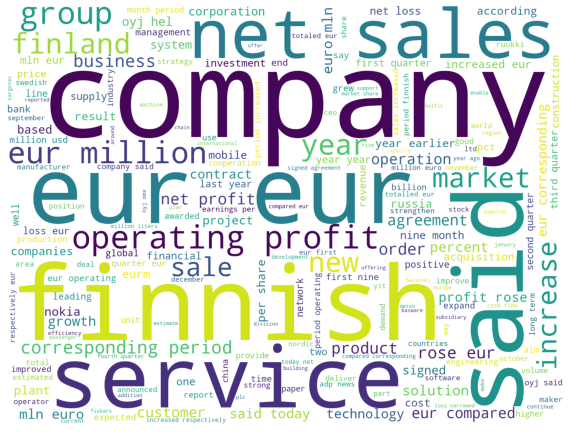

In [ ]:
plot_wordcloud(data[data['sentiment']=='positive'])

#### **Word Frequencies**

In [ ]:
def ngrams(input, n):
    """ INPUT : Sentence and number of n-grams
  OUTPUT N-Grams
  An n-gram is a contiguous sequence of n items from a given sample of text or speech.
  """
    output = []
    for i in range(len(input)-n+1):
        output.append('_'.join(input[i:i+n]))
    return output

In [ ]:
nltk.download('punkt')
tags = ['neutral','negative','positive'] 

df = data[data.sentiment.isin(tags)]
##Create N-Grams
df['Tokens'] = df.apply(lambda row: nltk.word_tokenize(row['text'].strip()), axis=1)
df['bi_Grams']  = df.apply(lambda row: ngrams(row['Tokens'], 2), axis=1)
df['tri_Grams']  = df.apply(lambda row: ngrams(row['Tokens'], 3), axis=1)
print(len(df),'samples from',len(tags),'classes')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


4846 samples from 3 classes


In [ ]:
c_unique = Counter()
for ind in df.index:
    c_unique.update(Counter(set(df.loc[ind]['Tokens'])))

print('First 20 common words:\n')
for word in c_unique.most_common(20):
    print(word[0],'-->', 'appeared in',word[1],'documents out of {} documents i.e.'.format(len(df)),np.round(100*word[1]/len(df),2),'%')


First 20 common words:

company --> appeared in 801 documents out of 4846 documents i.e. 16.53 %
eur --> appeared in 801 documents out of 4846 documents i.e. 16.53 %
said --> appeared in 544 documents out of 4846 documents i.e. 11.23 %
finnish --> appeared in 512 documents out of 4846 documents i.e. 10.57 %
sales --> appeared in 428 documents out of 4846 documents i.e. 8.83 %
profit --> appeared in 406 documents out of 4846 documents i.e. 8.38 %
net --> appeared in 384 documents out of 4846 documents i.e. 7.92 %
year --> appeared in 341 documents out of 4846 documents i.e. 7.04 %
finland --> appeared in 331 documents out of 4846 documents i.e. 6.83 %
million --> appeared in 311 documents out of 4846 documents i.e. 6.42 %
group --> appeared in 305 documents out of 4846 documents i.e. 6.29 %
operating --> appeared in 294 documents out of 4846 documents i.e. 6.07 %
new --> appeared in 261 documents out of 4846 documents i.e. 5.39 %
business --> appeared in 251 documents out of 4846 docume

**Labeling the data**

In [7]:
sent = data.sentiment.unique()
index = [i for i in range(len(sent.tolist()))]
label = dict(zip(sent, index))

sent = list(sent)
data['label'] = data.sentiment.replace(label)
data.head()

,sentiment,text,label
0,neutral,according gran company plans move production r...,0
1,neutral,technopolis plans develop stages area less squ...,0
2,negative,international electronic industry company elco...,1
3,positive,new production plant company would increase ca...,2
4,positive,according company updated strategy years baswa...,2


**Let's split the data now (70% train, 10% validation, 20% test)**

In [34]:
df_temp, df_test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['sentiment'])
df_train, df_val = train_test_split(df_temp, test_size=0.1, random_state=42, stratify=df_temp['sentiment'])

In [35]:
print("size of training set : " + str(df_train.shape[0]))
print("size of validation set : " + str(df_val.shape[0]))
print("size of test set : " + str(df_test.shape[0]))

size of training set : 3488
size of validation set : 388
size of test set : 970


Because the Data is imbalanced dataset, we will use oversampling as a mean to fix the imbalance but only on the training set.

In [36]:
from sklearn.utils import resample

sentiment = data.sentiment.unique()
max = 2
target_majority = data[data.sentiment==sentiment[max]]


for cl in range(3):
    train_minority = df_train[df_train.sentiment==sentiment[cl]]
    train_minority_upsampled = resample(train_minority, replace=True, n_samples=len(target_majority), random_state=33)
    if cl == 0:
        train_upsampled = pd.concat([train_minority_upsampled, target_majority])
        #train_upsampled = pd.concat([train_upsampled, ])
    if cl>0 and cl!=max:
        train_upsampled = pd.concat([train_minority_upsampled, train_upsampled])

train_upsampled['sentiment'].value_counts() 

negative    1363
neutral     1363
positive    1363
Name: sentiment, dtype: int64

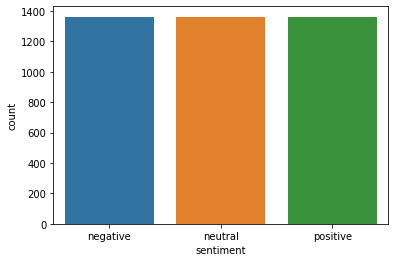

In [ ]:
sns.countplot(x="sentiment", data=train_upsampled)

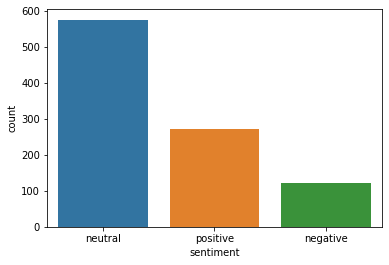

In [ ]:
sns.countplot(x="sentiment", data=df_test)

### **3. Classification model**

**3.1. Baseline: TF-IDF And Naive Bayes Classifier**

In [37]:
X_train = train_upsampled['text']
y_train = train_upsampled['label']

X_val = df_val['text']
y_val = df_val['label']

X_test = df_test['text']
y_test = df_test['label']

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
 	('transformer', Pipeline([
 		('vect', CountVectorizer()),
 		('tfidf', TfidfTransformer())
 	])),
 	('clf', MultinomialNB())
])

pipeline.fit(X_train,y_train)

Pipeline(steps=[('transformer',
                 Pipeline(steps=[('vect', CountVectorizer()),
                                 ('tfidf', TfidfTransformer())])),
                ('clf', MultinomialNB())])

In [39]:
def labels(x):
  if x == 0:
    return 'neutral'
  elif x == 1:
    return 'negative'
  else:
    return 'positive'

df_test_NB = df_test.copy()
predictions = pipeline.predict(X_test)

df_test_NB['Sentiment_pred'] = predictions
df_test_NB['Sentiment_pred'] = df_test_NB['Sentiment_pred'].map(labels)

df_test_NB['pred_label'] = predictions

df_test_NB.head()

,sentiment,text,label,Sentiment_pred,pred_label
2108,neutral,following payment made april company total eur...,0,neutral,0
4276,neutral,share subscription period options commence sep...,0,negative,1
478,neutral,aspocomp intends set plant manufacture printed...,0,neutral,0
810,positive,finnish rautaruukki awarded contract supply in...,2,positive,2
4648,negative,finnish bank _land reports operating profit fe...,1,negative,1


#### **Classification report of TF-IDF And Naive Bayes Classifier**

In [57]:
print('Classification_report of TF-IDF And Naive Bayes Classifier:')
print(classification_report(df_test_NB['sentiment'], df_test_NB['Sentiment_pred']))

Classification_report of TF-IDF And Naive Bayes Classifier:
              precision    recall  f1-score   support

    negative       0.41      0.77      0.54       121
     neutral       0.92      0.59      0.72       576
    positive       0.56      0.77      0.65       273

    accuracy                           0.66       970
   macro avg       0.63      0.71      0.64       970
weighted avg       0.76      0.66      0.68       970



### **3.2. BERT**

In [60]:
model = BertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=3)
tokenizer = BertTokenizer.from_pretrained("distilbert-base-uncased")

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/config.json
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Model config BertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dim": 768,
  "dropout": 0.1,
  "hidden_act": "gelu",
  "hidden_dim": 3072,
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "n_heads": 12,
  "n_layers": 6,
  "num

Prepare Dataset

In [61]:
dataset_train = Dataset.from_pandas(train_upsampled)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

dataset_train = dataset_train.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val = dataset_val.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test = dataset_test.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length' , max_length=128), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [62]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy' : accuracy_score(predictions, labels)}

In [63]:
args = TrainingArguments(
        output_dir = 'temp/',
        evaluation_strategy="steps",
        num_train_epochs=5,              
        per_device_train_batch_size=32,  
        per_device_eval_batch_size=64,   
        warmup_steps=500,                
        weight_decay=0.01,               
        logging_dir='./logs4',            
        #logging_steps=10,
        load_best_model_at_end=True,
)

using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [64]:
trainer = Trainer(
        model=model,                         
        args=args,                  
        train_dataset=dataset_train,         
        eval_dataset=dataset_val,           
        compute_metrics=compute_metrics
)

trainer.train() 

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__, sentiment. If text, __index_level_0__, sentiment are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 4089
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 640


Step,Training Loss,Validation Loss,Accuracy
500,0.890000,0.977246,0.636598


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__, sentiment. If text, __index_level_0__, sentiment are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 388
  Batch size = 64
Saving model checkpoint to temp/checkpoint-500
Configuration saved in temp/checkpoint-500/config.json
Model weights saved in temp/checkpoint-500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from temp/checkpoint-500 (score: 0.9772464632987976).


TrainOutput(global_step=640, training_loss=0.791755485534668, metrics={'train_runtime': 416.9271, 'train_samples_per_second': 49.037, 'train_steps_per_second': 1.535, 'total_flos': 1344838456362240.0, 'train_loss': 0.791755485534668, 'epoch': 5.0})

In [65]:
model.eval()
trainer.predict(dataset_test).metrics

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__, sentiment. If text, __index_level_0__, sentiment are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 970
  Batch size = 64


{'test_loss': 0.90652996301651,
 'test_accuracy': 0.6484536082474227,
 'test_runtime': 6.7697,
 'test_samples_per_second': 143.286,
 'test_steps_per_second': 2.363}

In [66]:
preds = trainer.predict(dataset_test)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__, sentiment. If text, __index_level_0__, sentiment are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 970
  Batch size = 64


In [67]:
probs = torch.from_numpy(preds[0]).softmax(1)
predictions = probs.numpy()# convert tensors to numpy array

new_df = pd.DataFrame(predictions,columns=data.sentiment.unique())
new_df.head()

,neutral,negative,positive
0,0.940049,0.000758,0.059193
1,0.554606,0.002416,0.442979
2,0.954011,0.000716,0.045273
3,0.071179,0.015931,0.912890
4,0.003038,0.980192,0.016769


In [68]:
df_test_bert = df_test.copy()

results = np.argmax(predictions,axis=1)

df_test_bert['Sentiment_pred'] = results
df_test_bert['Sentiment_pred'] = df_test_bert['Sentiment_pred'].map(labels)

df_test_bert['pred_label'] = results

df_test_bert.head()

,sentiment,text,label,Sentiment_pred,pred_label
2108,neutral,following payment made april company total eur...,0,neutral,0
4276,neutral,share subscription period options commence sep...,0,neutral,0
478,neutral,aspocomp intends set plant manufacture printed...,0,neutral,0
810,positive,finnish rautaruukki awarded contract supply in...,2,positive,2
4648,negative,finnish bank _land reports operating profit fe...,1,negative,1


#### **Classification report of BERT Model**

In [69]:
print('Classification_report of BERT Model:')
print(classification_report(df_test_bert['sentiment'], df_test_bert['Sentiment_pred']))

Classification_report of BERT Model:
              precision    recall  f1-score   support

    negative       0.72      0.36      0.48       121
     neutral       0.82      0.67      0.74       576
    positive       0.45      0.73      0.56       273

    accuracy                           0.65       970
   macro avg       0.66      0.59      0.59       970
weighted avg       0.71      0.65      0.66       970



### **3.3. FinBERT**

In [51]:
model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-pretrain',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--yiyanghkust--finbert-pretrain/snapshots/5b0dae12fea8ca5b3f256267ebe4e21786f3cfe5/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30873
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface

In [52]:
dataset_train = Dataset.from_pandas(train_upsampled)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

dataset_train = dataset_train.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val = dataset_val.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test = dataset_test.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length' , max_length=128), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [53]:
args = TrainingArguments(
        output_dir = 'temp/',
        evaluation_strategy="steps",
        num_train_epochs=5,              
        per_device_train_batch_size=32,  
        per_device_eval_batch_size=64,   
        warmup_steps=500,                
        weight_decay=0.01,               
        logging_dir='./logs4',            
        #logging_steps=10,
        load_best_model_at_end=True,
)
trainer = Trainer(
        model=model,                         
        args=args,                  
        train_dataset=dataset_train,         
        eval_dataset=dataset_val,           
        compute_metrics=compute_metrics
)

trainer.train() 

using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__, sentiment. If text, __index_level_0__, sentiment are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 4089
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 640


Step,Training Loss,Validation Loss,Accuracy
500,0.459900,0.542455,0.847938


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__, sentiment. If text, __index_level_0__, sentiment are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 388
  Batch size = 64
Saving model checkpoint to temp/checkpoint-500
Configuration saved in temp/checkpoint-500/config.json
Model weights saved in temp/checkpoint-500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from temp/checkpoint-500 (score: 0.5424549579620361).


TrainOutput(global_step=640, training_loss=0.38108848333358764, metrics={'train_runtime': 416.6519, 'train_samples_per_second': 49.07, 'train_steps_per_second': 1.536, 'total_flos': 1344838456362240.0, 'train_loss': 0.38108848333358764, 'epoch': 5.0})

In [54]:
model.eval()
trainer.predict(dataset_test).metrics

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__, sentiment. If text, __index_level_0__, sentiment are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 970
  Batch size = 64


{'test_loss': 0.5829560160636902,
 'test_accuracy': 0.8546391752577319,
 'test_runtime': 6.7832,
 'test_samples_per_second': 143.001,
 'test_steps_per_second': 2.359}

In [55]:
preds = trainer.predict(dataset_test)
probs = torch.from_numpy(preds[0]).softmax(1)
predictions = probs.numpy()# convert tensors to numpy array

new_df = pd.DataFrame(predictions,columns=data.sentiment.unique())

results = np.argmax(predictions,axis=1)

df_test_finbert = df_test.copy()

df_test_finbert['Sentiment_pred'] = results
df_test_finbert['Sentiment_pred'] = df_test_finbert['Sentiment_pred'].map(labels)

df_test_finbert['pred_label'] = results

df_test_finbert.head()


The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__, sentiment. If text, __index_level_0__, sentiment are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 970
  Batch size = 64


,sentiment,text,label,Sentiment_pred,pred_label
2108,neutral,following payment made april company total eur...,0,neutral,0
4276,neutral,share subscription period options commence sep...,0,neutral,0
478,neutral,aspocomp intends set plant manufacture printed...,0,neutral,0
810,positive,finnish rautaruukki awarded contract supply in...,2,positive,2
4648,negative,finnish bank _land reports operating profit fe...,1,negative,1


#### **Classification report of FinBERT Model**

In [58]:
print('Classification_report of FinBERT model:')
print(classification_report(df_test_finbert['sentiment'], df_test_finbert['Sentiment_pred']))

Classification_report of FinBERT model:
              precision    recall  f1-score   support

    negative       0.77      0.76      0.77       121
     neutral       0.94      0.82      0.88       576
    positive       0.76      0.96      0.85       273

    accuracy                           0.85       970
   macro avg       0.82      0.85      0.83       970
weighted avg       0.87      0.85      0.86       970

